# Laboratorium 10. (Dyskretna Transformacja Fouriera)

In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.fft import fft, ifft, fftfreq

## 1. FFT

### 1.1. Implementacje DFT, IDFT oraz rekurencyjnego algorytmu FFT Cooleya-Turkeya

In [2]:
def dft(x):
    n = len(x)
    X = np.zeros(n, dtype=complex)

    for k in range(n):
        for j in range(n):
            angle = -2 * math.pi * k * j / n
            X[k] += x[j] * (math.cos(angle) + 1j * math.sin(angle))

    return X


def idft(X):
    n = len(X)
    x = np.zeros(n, dtype=complex)

    for j in range(n):
        for k in range(n):
            angle = 2 * math.pi * k * j / n
            x[j] += X[k] * (math.cos(angle) + 1j * math.sin(angle))
        x[j] /= n

    return x


def fft_cooley_tukey(x):
    n = len(x)

    if n <= 1:
        return x

    even = fft_cooley_tukey(x[::2])
    odd = fft_cooley_tukey(x[1::2])

    T = [
        math.cos(-2 * math.pi * k / n) + 1j * math.sin(-2 * math.pi * k / n)
        for k in range(n // 2)
    ]

    return [even[k] + T[k] * odd[k] for k in range(n // 2)] + [
        even[k] - T[k] * odd[k] for k in range(n // 2)
    ]

### 1.2. Funkcja odpowiadająca za wizualizację wyników

In [3]:
def plot_benchmark_results(
    sizes, times_dft, times_fft, times_numpy, errors_dft, errors_fft
):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("FFT implementation comparison", fontsize=16, fontweight="bold")

    axes[0, 0].plot(sizes, times_dft, "o-", label="DFT", linewidth=2, markersize=6)
    axes[0, 0].plot(
        sizes, times_fft, "s-", label="FFT Cooley-Tukey", linewidth=2, markersize=6
    )
    axes[0, 0].plot(
        sizes, times_numpy, "^-", label="NumPy FFT", linewidth=2, markersize=6
    )
    axes[0, 0].set_xlabel("Vector size")
    axes[0, 0].set_ylabel("Execution time [s]")
    axes[0, 0].set_title("Execution times (linear scale)")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].loglog(sizes, times_dft, "o-", label="DFT", linewidth=2, markersize=6)
    axes[0, 1].loglog(
        sizes, times_fft, "s-", label="FFT Cooley-Tukey", linewidth=2, markersize=6
    )
    axes[0, 1].loglog(
        sizes, times_numpy, "^-", label="NumPy FFT", linewidth=2, markersize=6
    )
    axes[0, 1].set_xlabel("Vector size")
    axes[0, 1].set_ylabel("Execution time [s]")
    axes[0, 1].set_title("Execution times (log scale)")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    speedup = [times_dft[i] / times_fft[i] for i in range(len(sizes))]
    axes[1, 0].plot(sizes, speedup, "ro-", linewidth=2, markersize=6)
    axes[1, 0].set_xlabel("Vector size")
    axes[1, 0].set_ylabel("Factor")
    axes[1, 0].set_title("Speedup of FFT over DFT")
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].semilogy(
        sizes, errors_dft, "o-", label="DFT error", linewidth=2, markersize=6
    )
    axes[1, 1].semilogy(
        sizes, errors_fft, "s-", label="FFT error", linewidth=2, markersize=6
    )
    axes[1, 1].set_xlabel("Vector size")
    axes[1, 1].set_ylabel("Maximum error")
    axes[1, 1].set_title("Maximum error of DFT and FFT")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(pad=3.0)
    plt.show()

### 1.3. Funkcje testujące

In [4]:
def test_implementations():
    x = [1, 2, 3, 4]
    np.set_printoptions(precision=2, suppress=False)

    print("Input vector:", x)
    print()

    time_dft = time.time()
    X_dft = dft(x)
    time_dft = time.time() - time_dft
    print("DFT:", X_dft)

    x_recovered = idft(X_dft)
    print("IDFT:", x_recovered)

    x_rec_np = ifft(X_dft)

    x_padded = x + [0] * (4 - len(x) % 4) if len(x) % 4 != 0 else x
    time_fft = time.time()
    X_fft = fft_cooley_tukey(x_padded)
    time_fft = time.time() - time_fft
    print("FFT:", X_fft)

    time_np = time.time()
    X_numpy = fft(x)
    time_np = time.time() - time_np
    print("NumPy FFT:", X_numpy)
    print()

    print(f"DFT vs NumPy difference:  {np.max(np.abs(np.array(X_dft) - X_numpy)):.5e}")
    print(f"IDFT vs NumPy difference: {np.max(np.abs(np.array(x_recovered) - x_rec_np)):.5e}")
    print(f"FFT vs NumPy difference:  {np.max(np.abs(np.array(X_fft) - X_numpy)):.5e}")
    print()
    print(f"DFT time:       {time_dft:.6f}s")
    print(f"FFT time:       {time_fft:.6f}s")
    print(f"NumPy FFT time: {time_np:.6f}s")


def benchmark_implementations():
    sizes = [4, 8, 16, 32, 64, 128, 256, 512]
    times_dft = []
    times_fft = []
    times_numpy = []
    errors_dft = []
    errors_fft = []

    for size in sizes:
        x = np.random.random(size).tolist()

        start_time = time.time()
        X_dft = dft(x)
        time_dft = time.time() - start_time
        times_dft.append(time_dft)

        start_time = time.time()
        X_fft = fft_cooley_tukey(x)
        time_fft = time.time() - start_time
        times_fft.append(time_fft)

        start_time = time.time()
        X_numpy = fft(np.array(x))
        time_numpy = time.time() - start_time
        times_numpy.append(time_numpy)

        error_dft = np.max(np.abs(np.array(X_dft) - X_numpy))
        error_fft = np.max(np.abs(np.array(X_fft) - X_numpy))
        errors_dft.append(error_dft)
        errors_fft.append(error_fft)

    plot_benchmark_results(
        sizes, times_dft, times_fft, times_numpy, errors_dft, errors_fft
    )

    results = []
    for i, size in enumerate(sizes):
        speedup = times_dft[i] / times_fft[i] if times_fft[i] > 0 else 0
        results.append(
            {
                "Size": size,
                "DFT [s]": f"{times_dft[i]:.6f}",
                "FFT [s]": f"{times_fft[i]:.6f}",
                "NumPy FFT [s]": f"{times_numpy[i]:.6f}",
                "DFT error": f"{errors_dft[i]:.2e}",
                "FFT error": f"{errors_fft[i]:.2e}",
                "FFT speedup": f"{speedup:.1f}x",
            }
        )

    print("\nBenchmark results:")
    df = pd.DataFrame(results)

    return df

### 1.4. Wyniki

Input vector: [1, 2, 3, 4]

DFT: [10.+0.0e+00j -2.+2.0e+00j -2.-9.8e-16j -2.-2.0e+00j]
IDFT: [1.-5.55e-16j 2.-2.78e-16j 3.-1.11e-16j 4.+2.78e-16j]
FFT: [(10+0j), (-2+2j), (-2+0j), (-1.9999999999999998-2j)]
NumPy FFT: [10.+0.j -2.+2.j -2.+0.j -2.-2.j]

DFT vs NumPy difference:  1.98603e-15
IDFT vs NumPy difference: 5.22485e-16
FFT vs NumPy difference:  2.22045e-16

DFT time:       0.000060s
FFT time:       0.000016s
NumPy FFT time: 0.000026s


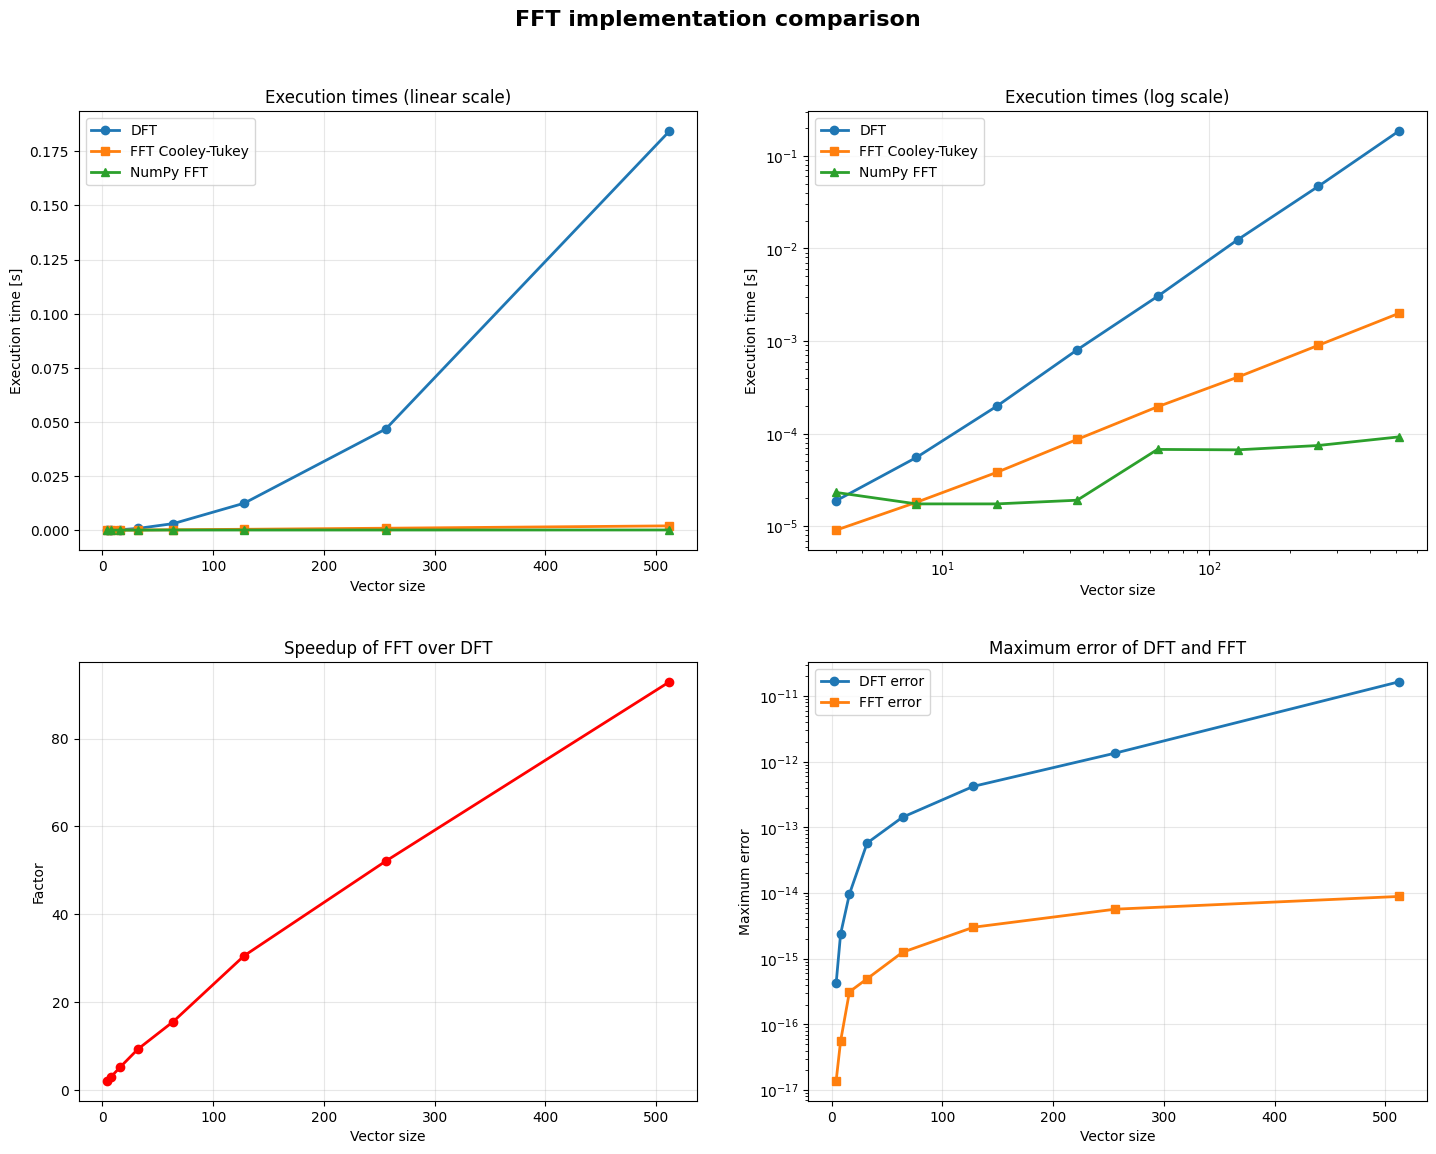


Benchmark results:


,Size,DFT [s],FFT [s],NumPy FFT [s],DFT error,FFT error,FFT speedup
0,4,0.000019,0.000009,0.000023,4.24e-16,1.39e-17,2.1x
1,8,0.000055,0.000018,0.000017,2.37e-15,5.55e-17,3.1x
2,16,0.000198,0.000038,0.000017,9.67e-15,3.14e-16,5.2x
3,32,0.000803,0.000087,0.000019,5.79e-14,4.97e-16,9.3x
4,64,0.003034,0.000195,0.000067,1.43e-13,1.26e-15,15.6x
5,128,0.012456,0.000408,0.000067,4.22e-13,3.02e-15,30.6x
6,256,0.046770,0.000897,0.000074,1.35e-12,5.69e-15,52.1x
7,512,0.184282,0.001983,0.000092,1.64e-11,8.88e-15,92.9x


In [5]:
test_implementations()
benchmark_implementations()

## 2. DFT w 1D

### 2.1. Generowanie sygnałów

In [6]:
def generate_signal_a(fs=1000, duration=1, frequencies=None):
    if frequencies is None:
        frequencies = [50, 120, 200]
    t = np.linspace(0, duration, fs * duration, endpoint=False)
    signal = np.zeros_like(t)

    for freq in frequencies:
        amplitude = 1.0 / len(frequencies)
        signal += amplitude * np.sin(2 * np.pi * freq * t)

    return t, signal


def generate_signal_b(fs=1000, duration=1, base_frequencies=None, intervals=5):
    if base_frequencies is None:
        base_frequencies = [50, 120, 200]
    t = np.linspace(0, duration, fs * duration, endpoint=False)
    signal = np.zeros_like(t)

    samples_per_interval = len(t) // intervals

    for i in range(intervals):
        start_idx = i * samples_per_interval
        end_idx = (i + 1) * samples_per_interval if i < intervals - 1 else len(t)

        freq = base_frequencies[i % len(base_frequencies)]
        t_interval = t[start_idx:end_idx]

        signal[start_idx:end_idx] = np.sin(2 * np.pi * freq * t_interval)

    return t, signal

### 2.2. Analiza wyników FFT

In [7]:
def analyze_fft_results(X, fs):
    n = len(X)
    frequencies = fftfreq(n, 1 / fs)

    magnitude = np.abs(X)
    phase = np.angle(X)

    real_part = X.real
    imaginary_part = X.imag

    return frequencies, magnitude, phase, real_part, imaginary_part

### 2.3. Wizualizacja wyników

In [8]:
def plot_signal_analysis(t, signal, X, fs, title):
    frequencies, magnitude, phase, real_part, imaginary_part = analyze_fft_results(
        X, fs
    )

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    axes[0, 0].plot(t, signal)
    axes[0, 0].set_title("Analyzed signal")
    axes[0, 0].set_xlabel("Time [s]")
    axes[0, 0].set_ylabel("Amplitude")
    axes[0, 0].grid(True)

    axes[0, 1].plot(
        frequencies[: len(frequencies) // 2], magnitude[: len(magnitude) // 2]
    )
    axes[0, 1].set_title("Amplitude spectrum")
    axes[0, 1].set_xlabel("Frequency [Hz]")
    axes[0, 1].set_ylabel("|X(f)|")
    axes[0, 1].grid(True)

    axes[0, 2].plot(frequencies[: len(frequencies) // 2], phase[: len(phase) // 2])
    axes[0, 2].set_title("Phase spectrum")
    axes[0, 2].set_xlabel("Frequency [Hz]")
    axes[0, 2].set_ylabel("Phase [rad]")
    axes[0, 2].grid(True)

    axes[1, 0].plot(
        frequencies[: len(frequencies) // 2], real_part[: len(real_part) // 2]
    )
    axes[1, 0].set_title("Real part")
    axes[1, 0].set_xlabel("Frequency [Hz]")
    axes[1, 0].set_ylabel("Re{X(f)}")
    axes[1, 0].grid(True)

    axes[1, 1].plot(
        frequencies[: len(frequencies) // 2], imaginary_part[: len(imaginary_part) // 2]
    )
    axes[1, 1].set_title("Imaginary part")
    axes[1, 1].set_xlabel("Frequency [Hz]")
    axes[1, 1].set_ylabel("Im{X(f)}")
    axes[1, 1].grid(True)

    axes[1, 2].scatter(real_part, imaginary_part, alpha=0.6, s=10)
    axes[1, 2].set_title("Complex plane")
    axes[1, 2].set_xlabel("Re{X(f)}")
    axes[1, 2].set_ylabel("Im{X(f)}")
    axes[1, 2].grid(True)
    axes[1, 2].axis("equal")

    plt.tight_layout()
    plt.show()

### 2.4. Wyniki

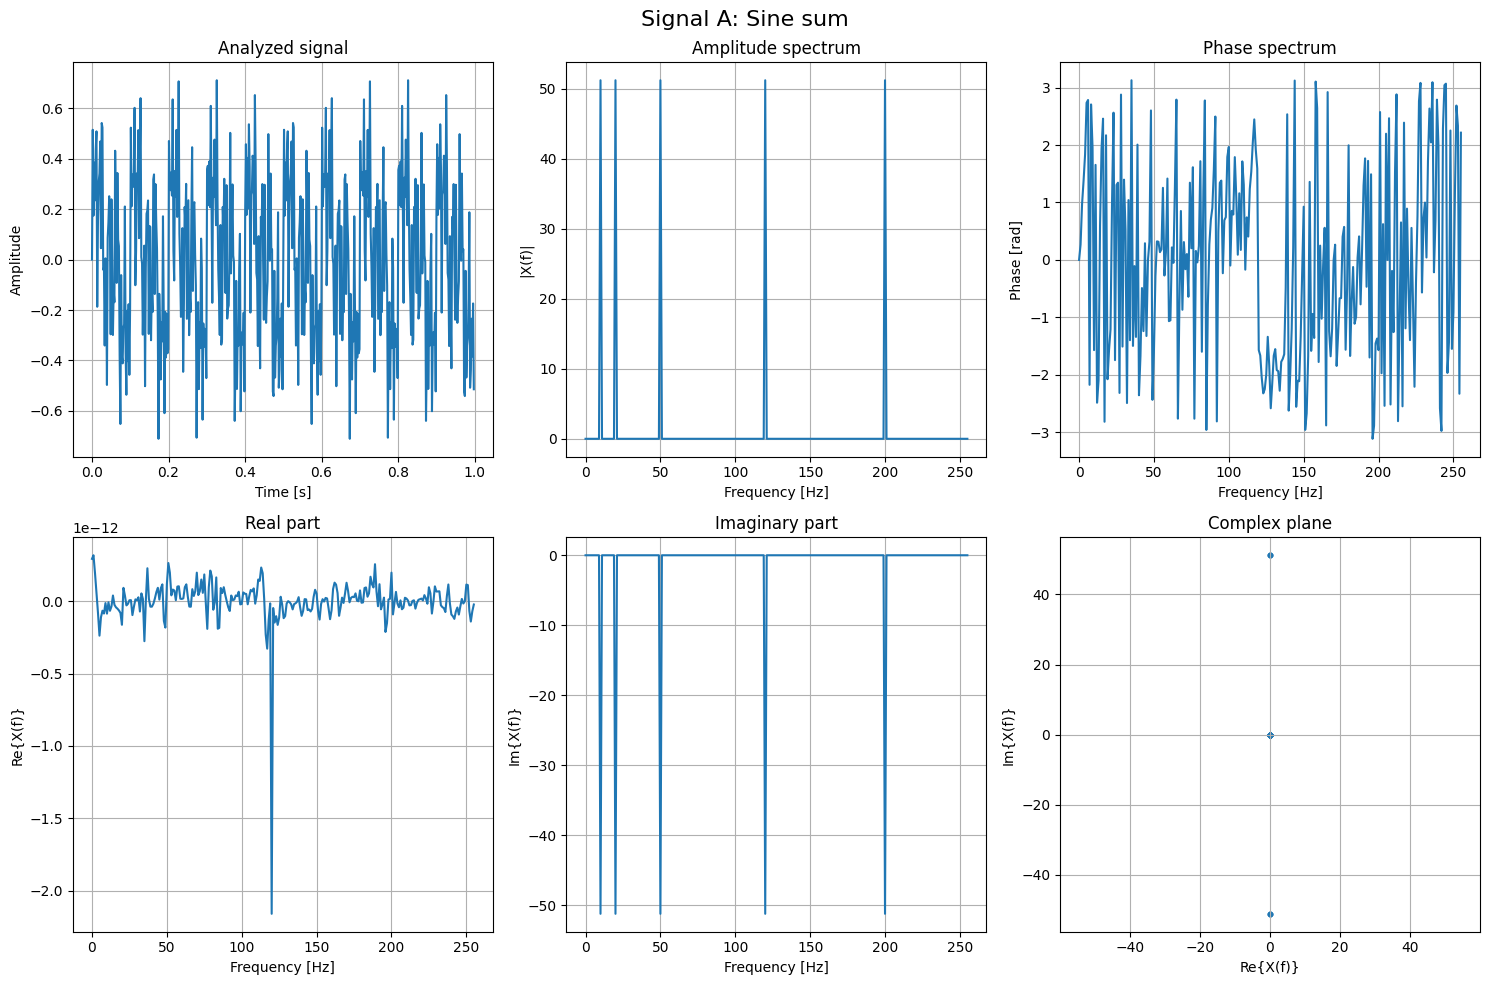

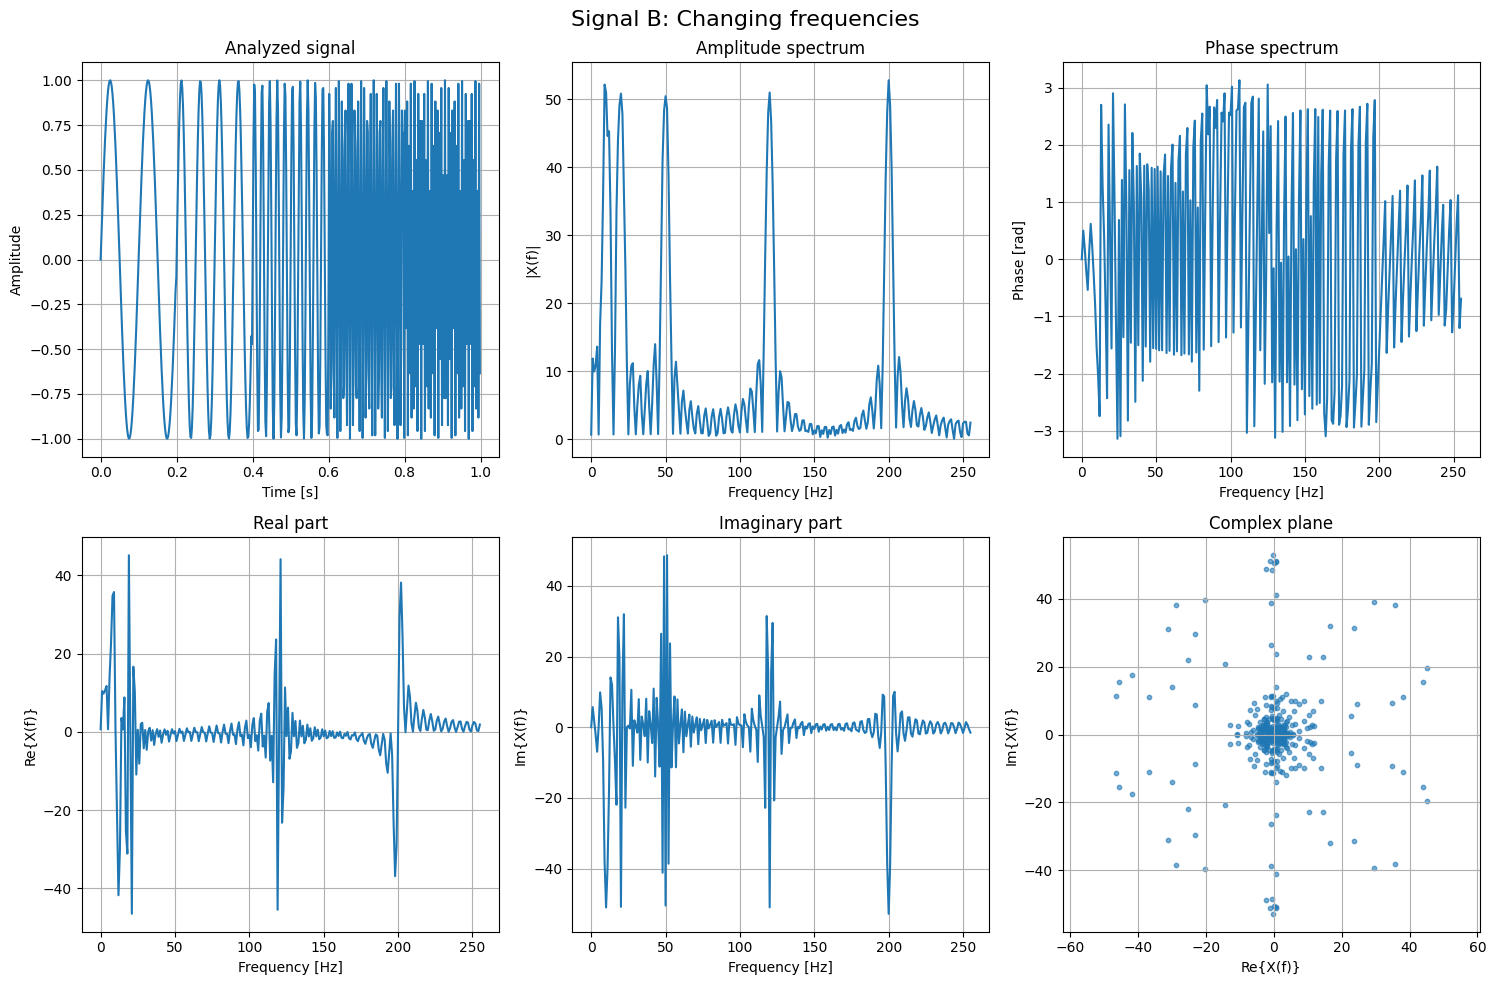

In [9]:
fs = 512
duration = 1

t_a, signal_a = generate_signal_a(fs, duration, [10, 20, 50, 120, 200])
X_a = fft(signal_a)
plot_signal_analysis(t_a, signal_a, X_a, fs, "Signal A: Sine sum")

t_b, signal_b = generate_signal_b(fs, duration, [10, 20, 50, 120, 200], 5)
X_b = fft(signal_b)
plot_signal_analysis(t_b, signal_b, X_b, fs, "Signal B: Changing frequencies")